In [ ]:
# This code is intended to fulfill the requirements for York University CSML1010 Independent Project Milestone 3.
# This notebook has been edited by Kathryn Renton and designed for learning purposes only.

# **Independent Milestone 3 - Job Analysis - Part 2**

Question: How do we predict the number of views for each job posting based on multiple features from the dataset? The answer to this question helps one to understand the factors that influence the popularity of job listings. Knowing this information, could aid companies and employers in optimizing their job postings for increased engagement. Increased engagement could then lead to increased quantity of applications, and increased chances that quality candidates would be referred, apply and be hired.

To answer this question, numeric, categorical and natural language processing will be utilized. Specifically, some previous data cleaning and lemmatization of job description text will be leveraged from the previous milestone. N-grams extraction from job descriptions and job titles will be included, along with some additional data processing, and debugging. A random forest regression model will be fit, trained, and evaluated.

The original data is from this [link](https://www.kaggle.com/datasets/adampq/).

In [ ]:
#importing packages for processing and visualizing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#here we load the data
l_jobs = pd.read_csv("l_jobs.csv")

In [ ]:
#now we view the data frame to get a sense of the data set columns, rows, and values
display(linkedin_jobs)

,Co_Nm,Co_Pg_Lstd,Emp_Cnt,Flw_Cnt,Job_Ttl,Job_Desc,Is_Supvsr,max_sal,med_sal,min_sal,...,st_code,is_remote,views,app_typ,app_is_off,xp_lvl,domain,has_post_domain,is_sponsored,base_comp
0,HearingLife,True,1171,11417,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,False,5250.00,5250.00,5250.00,...,SC,0,9,OffsiteApply,True,Entry level,careers-demant.icims.com,True,0,1
1,"Metalcraft of Mayville, Inc.",True,300,2923,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,False,0.00,0.00,0.00,...,WI,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
2,"U.S. Tsubaki Power Transmission, LLC",True,314,8487,"Manager, Engineering",The TSUBAKI name is synonymous with excellence...,True,0.00,0.00,0.00,...,AL,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
3,Episcopal Communities & Services,True,36,305,Cook,descriptionTitle\n\n Looking for a great oppor...,False,22.27,22.27,22.27,...,CA,0,1,OffsiteApply,True,Entry level,jobs.apploi.com,True,0,1
4,"iHerb, LLC",True,1227,51933,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",False,275834.00,240895.00,205956.00,...,XF,1,0,OffsiteApply,True,Mid-Senior level,careers.iherb.com,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,Crowe,True,9109,134126,Private Equity Tax Manager,Your Journey at Crowe Starts Here:\n\nAt Crowe...,True,183368.00,136564.00,89760.00,...,MA,0,2,OffsiteApply,True,Not Listed,careers.crowe.com,True,0,1
33242,"Anders Group, LLC",True,170,6051,Travel Ultrasound Tech - General - 679953,Description\n\nUltrasound Tech - General Ultra...,False,0.00,0.00,0.00,...,SC,0,0,OffsiteApply,True,Mid-Senior level,jobs.andersgroup.org,True,1,0
33243,Crowe,True,9109,134126,Senior Auditor - Financial Services,Your Journey at Crowe Starts Here:\n\nAt Crowe...,True,127802.00,95181.00,62560.00,...,CA,0,0,OffsiteApply,True,Not Listed,careers.crowe.com,True,0,1
33244,"Anders Group, LLC",True,170,6051,Travel Registered Nurse OR Operating Room - 68...,Description\n\nRegistered Nurse OR Operating R...,False,0.00,0.00,0.00,...,XF,0,0,OffsiteApply,True,Mid-Senior level,jobs.andersgroup.org,True,0,0


Data Preprocessing

In [ ]:
#let's drop rows with null values
linkedin_jobs.dropna(inplace=True)

In [ ]:
#let's also drop post domain as due to dropping rows with empty values this row becomes not useful for this analysis
linkedin_jobs = linkedin_jobs.drop('has_post_domain', axis=1)

In [ ]:
#removing outliers for 'views'
Q1v = linkedin_jobs['views'].quantile(0.25)
Q3v = linkedin_jobs['views'].quantile(0.75)
IQRv = Q3v - Q1v
linkedin_jobs = linkedin_jobs[~((linkedin_jobs['views'] < (Q1v - 1.5 * IQRv)) | (linkedin_jobs['views'] > (Q3v + 1.5 * IQRv)))]

In [ ]:
#now we review the data frame to see if 'has post domain' was dropped along with outliers
display(linkedin_jobs)

,Co_Nm,Co_Pg_Lstd,Emp_Cnt,Flw_Cnt,Job_Ttl,Job_Desc,Is_Supvsr,max_sal,med_sal,min_sal,...,loc,st_code,is_remote,views,app_typ,app_is_off,xp_lvl,domain,is_sponsored,base_comp
0,HearingLife,True,1171,11417,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,False,5250.00,5250.00,5250.00,...,"Little River, SC",SC,0,9,OffsiteApply,True,Entry level,careers-demant.icims.com,0,1
1,"Metalcraft of Mayville, Inc.",True,300,2923,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,False,0.00,0.00,0.00,...,"Beaver Dam, WI",WI,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,0,0
2,"U.S. Tsubaki Power Transmission, LLC",True,314,8487,"Manager, Engineering",The TSUBAKI name is synonymous with excellence...,True,0.00,0.00,0.00,...,"Bessemer, AL",AL,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,0,0
3,Episcopal Communities & Services,True,36,305,Cook,descriptionTitle\n\n Looking for a great oppor...,False,22.27,22.27,22.27,...,"Aliso Viejo, CA",CA,0,1,OffsiteApply,True,Entry level,jobs.apploi.com,0,1
4,"iHerb, LLC",True,1227,51933,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",False,275834.00,240895.00,205956.00,...,United States,XF,1,0,OffsiteApply,True,Mid-Senior level,careers.iherb.com,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,Crowe,True,9109,134126,Private Equity Tax Manager,Your Journey at Crowe Starts Here:\n\nAt Crowe...,True,183368.00,136564.00,89760.00,...,"Boston, MA",MA,0,2,OffsiteApply,True,Not Listed,careers.crowe.com,0,1
33242,"Anders Group, LLC",True,170,6051,Travel Ultrasound Tech - General - 679953,Description\n\nUltrasound Tech - General Ultra...,False,0.00,0.00,0.00,...,"Greenville, SC",SC,0,0,OffsiteApply,True,Mid-Senior level,jobs.andersgroup.org,1,0
33243,Crowe,True,9109,134126,Senior Auditor - Financial Services,Your Journey at Crowe Starts Here:\n\nAt Crowe...,True,127802.00,95181.00,62560.00,...,"Los Angeles, CA",CA,0,0,OffsiteApply,True,Not Listed,careers.crowe.com,0,1
33244,"Anders Group, LLC",True,170,6051,Travel Registered Nurse OR Operating Room - 68...,Description\n\nRegistered Nurse OR Operating R...,False,0.00,0.00,0.00,...,"Aurora, Colorado, United States",XF,0,0,OffsiteApply,True,Mid-Senior level,jobs.andersgroup.org,0,0


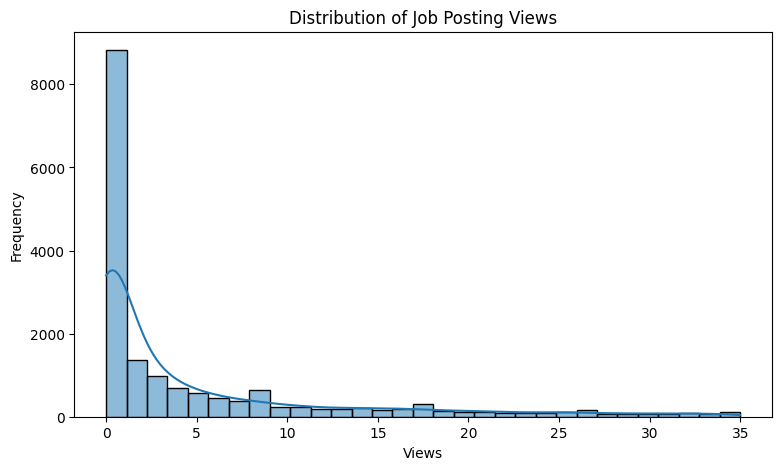

In [ ]:
#let's look at the distribution of view numbers with the kernel density estimate
plt.figure(figsize=(9, 5))
sns.histplot(linkedin_jobs['views'], bins=31, kde=True)
plt.title('Distribution of Job Posting Views')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#cleaning code from independent milestone 2
#Here we run the function to convert NLTK tag to WordNet tag
#NLTK provides Part of Speech tagging to label tags based on the context of each word in the text (e.g,, noun, verb, etc.)
#by converting the tags, this allows the lemmatizer to process the words based on their POS tags.
#This is crucial because the lemma (base) of a word can differ based on its part of speech.
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
#now we perform some text preprocessing and lemmatization
#for example, "running" as a verb will be lemmatized to "run", but as a noun, it remains "running".
def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)#removing whitespace: e.g., tabs, newlines, etc.
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) #removing non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

#applying preprocessing to job descriptions
linkedin_jobs['Job_Desc_Clean'] = linkedin_jobs['Job_Desc'].apply(preprocess_text)

In [ ]:
#there are still some high frequency characters appearing that have little meaning in this context
#let's remove them as they will overshadow the themes we want to discern

#first we will define the list of words to remove
words_to_remove = ['www', 'â']

#here is the function to remove specified words
def remove_unwanted_words(text):
    return ' '.join(word for word in text.split() if word not in words_to_remove)

#now we apply that function to the data frame
linkedin_jobs['Job_Desc_Clean'] = linkedin_jobs['Job_Desc_Clean'].apply(remove_unwanted_words)

Feature Engineering

In [ ]:
#importing the model prep, model and model evaluation modules
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
#feature engineering with job titles using TfidfVectorizer n-grams (and limiting max features from 1000 to 500)
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2))  #using bigrams as well as unigrams
job_titles = linkedin_jobs['Job_Ttl'].fillna('')  #replacing NaNs with empty strings
job_title_matrix = vectorizer.fit_transform(job_titles)

In [ ]:
#next, feature engineering with job descriptions
job_descs = linkedin_jobs['Job_Desc_Clean'].fillna('')
job_desc_matrix = vectorizer.fit_transform(job_descs)

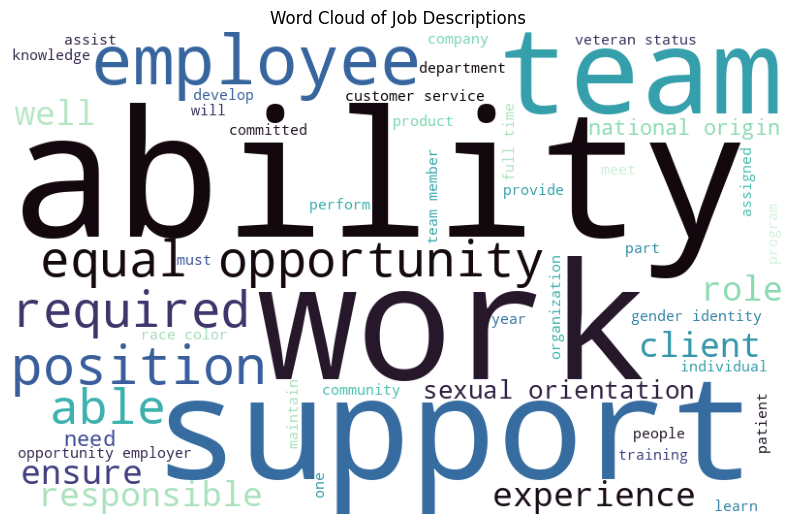

In [ ]:
#concatenate all job descriptions into a single string to make a word cloud (job descriptions)
all_job_descs = ' '.join(linkedin_jobs['Job_Desc_Clean'].fillna(''))
#make the word cloud
wordcloud = WordCloud(width=800, height=500, random_state=20, max_words=50, background_color='white', colormap='mako').generate(all_job_descs)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Job Descriptions')
plt.show()

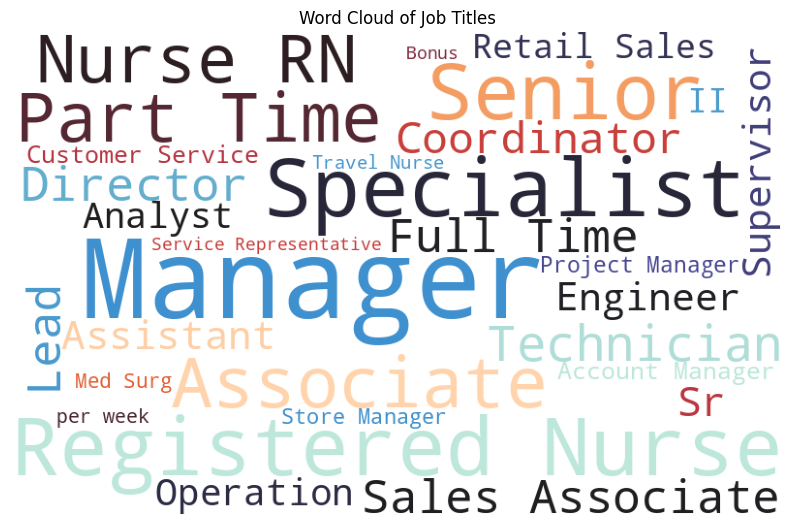

In [ ]:
#same except concatenate all job titles
all_job_titles = ' '.join(linkedin_jobs['Job_Ttl'].fillna(''))
#make the word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=30, background_color='white', colormap='icefire').generate(all_job_titles)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Job Titles')
plt.show()

Preparing for the Model

In [ ]:
#next we define the target variable (views)
y = linkedin_jobs['views']
X = linkedin_jobs.drop('views', axis=1)

In [ ]:
#here we pull the numeric (int64) and categorical (float) columns, including open-ended text data (job_description and title)
text_features = ['Job_Desc_Clean', 'Job_Ttl']
numeric_features = linkedin_jobs.select_dtypes(include=['int64', 'float64']).columns.drop('views')
categorical_features = linkedin_jobs.select_dtypes(include=['object']).columns.drop(text_features)

In [ ]:
#here we build the preprocessors for each feature type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2)))])

#then we merge preprocessing for all feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text1', text_transformer, text_features[0]),
        ('text2', text_transformer, text_features[1])
    ])

In [ ]:
#below is the pipeline we just created - preprocessing leading into the Random Forest Model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=15, #low number to help the model train faster
                                        min_samples_split=10,  #increased the # help model train faster
                                        min_samples_leaf=4,    #increased the # to help model train faster
                                        random_state=52))
])

In [ ]:
#then we split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

Fit the Model

In [ ]:
#...and fit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Emp_Cnt', 'Flw_Cnt', 'max_sal', 'med_sal', 'min_sal', 'is_remote',
       'is_sponsored', 'base_comp'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),...
                                                  Index(['Co_Nm', 'Job_Desc', 'py_prd', 'wrk_typ', 'loc', 'st_code', 'app_typ',
       'xp_lvl', 'domain'],
      dtype='object')),
                                                 ('text1',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'Job_Desc_Clean'),
                                                 ('text2',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'Job_Ttl')])),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=15, random_state=52))])

In [ ]:
#then we predict on the test set
y_pred = pipeline.predict(X_test)

In [ ]:
#and calculate the MSE and R-squared values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#...and view the results
print(f'Random Forest Mean Squared Error: {mse}')
print(f'Random Forest R-squared: {r2}')

Random Forest Mean Squared Error: 43.85069473322162
Random Forest R-squared: 0.28397887327763427


In [ ]:
#then we x-validate the R-squared scores (with lower folds to decrease the x-validation time)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='r2')
print(f'Cross-validated R-squared scores for Random Forest: {cv_scores}')
print(f'Mean CV R-squared for Random Forest: {np.mean(cv_scores)}')

Cross-validated R-squared scores for Random Forest: [0.2516415  0.24986607 0.24181673]
Mean CV R-squared for Random Forest: 0.24777476709824253


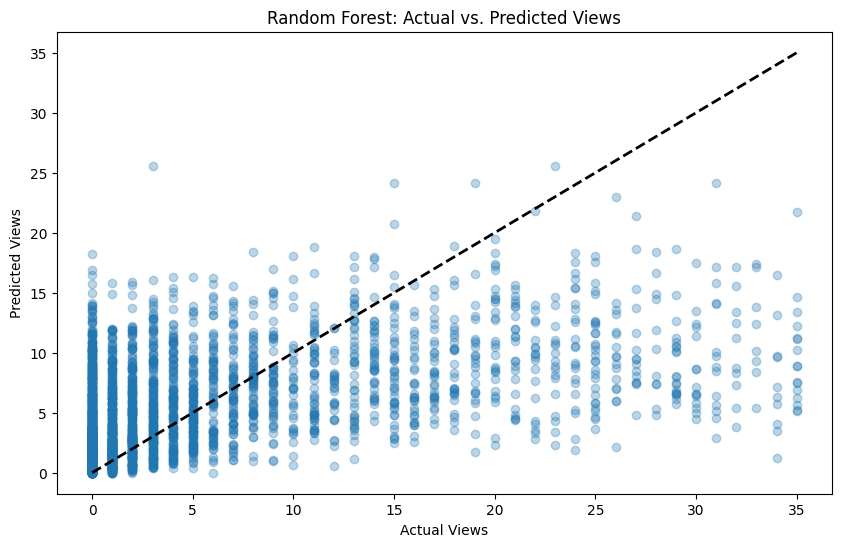

In [ ]:
#...and here we plot the actual vs. predicted values utilzing the Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Random Forest: Actual vs. Predicted Views')
plt.show()

**Conclusion**

The final Random Forest Regression model displayed an R Squared value of approximately .28. The cross-validation is similar to the first set of results which helps to reinforce the models' generalizability across other samples of the data. The scatterplot of actual vs. predicted views shows the models' performance - the data points fall somewhat along the grid line, however, the data is not tightly fitted.

The results may be improved by:

Feature selection – evaluating the different features and removing those that could be contributing to noise in the model

Ensemble Learning – combining different models using boosting or stacking for better performance

Hyperparameter tuning – for the Random Forest changing the number of trees, depth of trees, samples per leaf or using grid search or random search to find optimal values
